# Toxic Comment Classifier

Below is a classifier for the Jigsaw [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge) hosted by Kaggle, written in Keras/TF. This model leverages multiple insights from high-scoring Kaggle kernels, as well as exploratory work in PyTorch's Torchtext library.

In this notebook I compare a simply bidirectional LSTM with a more complex bi-GRU-ConvNet. I also implement a simple linear model: a Naïve Bayes Support Vector Machine, and try out various combinations of ensembles.

This notebook can be run linearly, although multiple runs may be desired to load and train different neural-net models: since Jupyter (as of yet) does not release GPU memory once it is allocated. There are points in the notebook where blocks of code are commented out: in most cases these are data preprocessing steps - meant to be run once - and the preprocessed data is saved to disk for quick access. In other cases these are options between loading GloVe or fastText word vector embeddings.

The data used in this notebook must be downloaded before running. The data was obtained from the Jigsaw [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge) Kaggle competition. Lastly, this notebook assumes the correct data directory structure is set up. You can simply recreate the structure in the Paths section below, or make your own changes. Viewing this notebook in Jupyter is recommended so you can use the collapsible headers for easy navigation (provided you have them, see: [Jupyter Extensions](https://github.com/ipython-contrib/jupyter_contrib_nbextensions)).

**Final Note**: an ensemble of an NB-SVM, and LSTM and GRU with fastText embeddings achieved the highest AUC-ROC score of 0.9830 (98.3% true-positive classification rate).

**See Aside 1** for terms.

-- Wayne Nixalo 1/4/2018

---

## 1. Imports & Config

Imports & Paths

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import pathlib
import pandas as pd
import numpy as np

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from keras.layers import SpatialDropout1D
from keras.layers import Bidirectional
from keras.layers import GRU
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import concatenate
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

import pickle
import bcolz
import time
import os

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
%%time
PATH_DATA = pathlib.Path('../../data')
PATH_COMP = PATH_DATA/'competitions/jigsaw-toxic-comment-classification-challenge'
TRAIN_FILE = 'train.csv'
TEST_FILE  = 'test.csv'
EMBEDDING_GLOVE    = PATH_DATA/'glove/glove.6B.50d.txt'
EMBEDDING_FASTTEXT = PATH_DATA/'fasttext/crawl-300d-2M.vec'

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 75.1 µs


Basic Config Parameters

In [4]:
%%time
embed_sz = 50    # embedding vector length
max_feat = 20000 # num unique words
maxlen   = 100   # max length of sequence to read

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.44 µs


---

## 2. Data Preprocessing & Embeddings

**See: Aside 2**

In [5]:
%%time
# read data & replace missing values
train_df = pd.read_csv(PATH_COMP/TRAIN_FILE)
test_df  = pd.read_csv(PATH_COMP/TEST_FILE)

list_sentences_train = train_df["comment_text"].fillna("_na_").values
list_sentences_test  = test_df["comment_text"].fillna("_na_").values

list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
labels = train_df[list_classes].values

CPU times: user 1.42 s, sys: 144 ms, total: 1.57 s
Wall time: 1.57 s


In [6]:
%%time
# tokenize, numericalize, and pad
tokenizer = Tokenizer(num_words=max_feat, lower=True, oov_token='<unk>')
tokenizer.fit_on_texts(list(list_sentences_train))

list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test  = tokenizer.texts_to_sequences(list_sentences_test)

input_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
input_test  = pad_sequences(list_tokenized_test, maxlen=maxlen)

CPU times: user 29.1 s, sys: 256 ms, total: 29.4 s
Wall time: 29 s


Writing preprocessed data to disk **See: Aside 3**

In [7]:
%%time
PATH_BC = PATH_COMP/'tmp/bc'
os.makedirs(PATH_BC, exist_ok=True)

# WRITE
bcolz.carray(list_tokenized_train, rootdir=PATH_BC/'list_tokenized_train', mode='w').flush()
bcolz.carray(list_tokenized_test, rootdir=PATH_BC/'list_tokenized_test', mode='w').flush()
bcolz.carray(input_train, rootdir=PATH_BC/'input_train', mode='w').flush()
bcolz.carray(input_test,  rootdir=PATH_BC/'input_test',  mode='w').flush()

# READ
list_tokenized_train = np.asarray(bcolz.open(rootdir=PATH_BC/'list_tokenized_train'))
list_tokenized_test  = np.asarray(bcolz.open(rootdir=PATH_BC/'list_tokenized_test'))
input_train          = np.asarray(bcolz.open(rootdir=PATH_BC/'input_train'))
input_test           = np.asarray(bcolz.open(rootdir=PATH_BC/'input_test'))

CPU times: user 23.9 s, sys: 15.2 s, total: 39.1 s
Wall time: 1min 1s


Load pretrained word vectors (GloVe or fastText) into word->vector dictionary **See: Aside 4**

In [11]:
%%time
# build word-vector lookup dictionary
def get_coefficients(word, *arr):
    """return a word and an ndarray of its associated vector embedding"""
    return word, np.asarray(arr, dtype='float32')

# GloVe embeddings
# embeddings_index = dict(get_coefficients(*o.strip().split()) for o in open(EMBEDDING_GLOVE))

# fastText embeddings
# embeddings_index = dict(get_coefficients(*o.strip().split()) for o in open(EMBEDDING_FASTTEXT))

# fastText embeddings_index is very large - save/load to disk -  3 min -> 9 sec
# pickle.dump(embeddings_index, open(PATH_COMP/'fasttext_embeddings_index.pickle', 'wb'))
embeddings_index = pickle.load(open(PATH_COMP/'fasttext_embeddings_index.pickle', 'rb'))

CPU times: user 8.11 s, sys: 836 ms, total: 8.95 s
Wall time: 8.89 s


'fixing' fastText embeddings

In [14]:
%%time
# some fastText embeddings are 299D instead of 300D; breaking np.stack.
# I fix this by concatenating the mean & stdev to the 'short' vectors

# get Mean & StdDev of Embeddings Matrix
fasttext_values = np.concatenate([vec for vec in embeddings_index.values()])
emb_mean = fasttext_values.mean()
emb_stdv = fasttext_values.std()

# Find all short Word Vectors
shortkeys = [key for key in iter(embeddings_index.keys()) 
                     if len(embeddings_index[key]) < 300]

# in this case I know there are 5 keys off by 1
rand_nums = np.random.normal(emb_mean, emb_stdv, len(shortkeys))

# 'fix' short Word Vectors
for i,key in enumerate(shortkeys):
    embeddings_index[key] = np.concatenate((embeddings_index[key], np.array([rand_nums[i]])))

CPU times: user 3.76 s, sys: 1.12 s, total: 4.88 s
Wall time: 4.04 s


In [15]:
# if you want to use embedding size of the pretrained vectors:
embed_sz = len(embeddings_index[next(iter(embeddings_index.keys()))])

Build Embedding Matrix. Randomly initialize out-of-vocab words to the mean & standard deviation of the embeddings.

In [16]:
%%time
embeddings = np.stack(embeddings_index.values())
emb_mean   = embeddings.mean()
emb_stdv   = embeddings.std()

CPU times: user 7.67 s, sys: 2.45 s, total: 10.1 s
Wall time: 8.44 s


In [17]:
%%time
n_words = min(max_feat, tokenizer.num_words)
embedding_matrix = np.random.normal(emb_mean, emb_stdv, (n_words, embed_sz))

# build using the first `max_feat` most common words
for word, i in tokenizer.word_index.items():
    if i >= max_feat:
        continue
    embedding_vector = embeddings_index.get(word)
    
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

CPU times: user 316 ms, sys: 20 ms, total: 336 ms
Wall time: 335 ms


### NB-SVM

Processing for the NB-SVM classifier **See: Aside 5**

In [18]:
%%time
# create 'None' label for unlabeled classes
train_df["none"] = 1 - train_df[list_classes].max(axis=1)

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 14.9 ms


Build Term-Document Matrix for NB-SVM, using TF-IDF to create priors:

In [19]:
# to stay consistent, I wanted to use the same tokenizer.
# adapted from the Keras source code: https://github.com/keras-team/keras/blob/master/keras/preprocessing/text.py#L290:23
def keras_tokenizer(s):
    seq = text_to_word_sequence(s, tokenizer.filters, tokenizer.lower, tokenizer.split)
    return seq

In [20]:
%%time
# quick hack to get Keras' vocab into Sklearn. (Keras 1-index; Sklearn 0-index)
nbsvm_vocab  = {key:tokenizer.word_index[key] - 1 for key in tokenizer.word_index.keys()}

# using Keras vocab
# tfidf_vectorizer = TfidfVectorizer(
#     ngram_range=(1,4), tokenizer=keras_tokenizer, vocabulary=nbsvm_vocab, 
#     strip_accents='unicode', use_idf=1, smooth_idf=1, sublinear_tf=1
# )

# building new vocab
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1,2), tokenizer=keras_tokenizer, min_df=3, max_df=0.9,
    strip_accents='unicode', use_idf=1, smooth_idf=1, sublinear_tf=1
)

train_term_doc = tfidf_vectorizer.fit_transform(train_df["comment_text"])
test_term_doc  = tfidf_vectorizer.transform(test_df["comment_text"])

CPU times: user 1min 2s, sys: 688 ms, total: 1min 3s
Wall time: 1min 2s


---

## 3. Architecture Design

In [21]:
# naive bayes feature equation
def pr(x, y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum() + 1)

# fit model for one dependent-variable at a time
def get_mdl(x,y):
    y = y.values
    r = np.log(pr(x, 1, y) / pr(x, 0, y))
    m = LogisticRegression(C=4, dual=True)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [22]:
def BiLSTM():
    m_input = Input(shape=(maxlen,))
    x = Embedding(max_feat, embed_sz, weights=[embedding_matrix])(m_input)
    x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
    x = GlobalMaxPool1D()(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(len(list_classes), activation="sigmoid")(x)
    
    return keras.models.Model(inputs=m_input, outputs=x)

In [23]:
def BiGRU_ConvNet():
    m_input = Input(shape=(maxlen,))
    x = Embedding(max_feat, embed_sz, weights=[embedding_matrix], trainable=False)(m_input)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(GRU(128, return_sequences=True,dropout=0.1, recurrent_dropout=0.1))(x)
    x = Conv1D(64, kernel_size=3)(x)
    x = concatenate([
            GlobalAveragePooling1D()(x), 
            GlobalMaxPooling1D()(x)
        ])
    x = Dense(len(list_classes), activation="sigmoid")(x)
    
    return Model(inputs=m_input, outputs=x)

### 3.1 Model Checkpoints

In [24]:
PATH_CHECKPOINT = PATH_COMP/'checkpoints/'
os.makedirs(PATH_CHECKPOINT, exist_ok=True)

# GloVe run
# fpath_LSTM = PATH_CHECKPOINT/'lstm_glove_best.hdf5'
# fpath_GRU  = PATH_CHECKPOINT/'gru_glove_best.hdf5'

# fastText run
fpath_LSTM = PATH_CHECKPOINT/'lstm_fasttext_best.hdf5'
fpath_GRU  = PATH_CHECKPOINT/'gru_fasttext_best.hdf5'

In [25]:
def create_checkpoint(fpath):
    return ModelCheckpoint(f'{str(fpath)}', monitor='val_acc', 
                           verbose=1, save_best_only=True, mode='max')

---

## 4. Training

### 4.1 NB-SVM

In [75]:
NBSVM_predictions = np.zeros((len(test_df), len(list_classes)))

# fit-loop
for i, clss in enumerate(list_classes):
    print('fit', clss)
    m, r = get_mdl(train_term_doc, train_df[clss])
    NBSVM_predictions[:,i] = m.predict_proba(test_term_doc.multiply(r))[:,1]

fit toxic
fit severe_toxic
fit obscene
fit threat
fit insult
fit identity_hate


### 4.2 LSTM

In [137]:
model = BiLSTM()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
checkpoint = [create_checkpoint(fpath_LSTM)]

In [138]:
model.fit(input_train, labels, batch_size=64, epochs=2, 
          validation_split=0.1, callbacks=checkpoint)

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143552/143613 [============================>.] - ETA: 0s - loss: 0.0596 - acc: 0.9795
Epoch 00001: val_acc improved from -inf to 0.98269, saving model to ../../data/competitions/jigsaw-toxic-comment-classification-challenge/checkpoints/lstm_fasttext_best.hdf5
143613/143613 [==============================] - 800s 6ms/step - loss: 0.0595 - acc: 0.9795 - val_loss: 0.0459 - val_acc: 0.9827
Epoch 2/2
143552/143613 [============================>.] - ETA: 0s - loss: 0.0415 - acc: 0.9841
Epoch 00002: val_acc did not improve
143613/143613 [==============================] - 799s 6ms/step - loss: 0.0415 - acc: 0.9841 - val_loss: 0.0469 - val_acc: 0.9826


In [15]:
model = BiLSTM()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [16]:
# final training run uses full dataset
model.fit(input_train, labels, batch_size=64, epochs=2)
model.save(fpath_LSTM)

Epoch 1/2
159571/159571 [==============================] - 876s 5ms/step - loss: 0.0575 - acc: 0.9799
Epoch 2/2
159571/159571 [==============================] - 864s 5ms/step - loss: 0.0410 - acc: 0.9842


### 4.3 GRU+Conv

In [17]:
model = BiGRU_ConvNet()
model.compile(optimizer="adam", loss='binary_crossentropy',metrics=['accuracy'])
checkpoint = [create_checkpoint(fpath_GRU)]

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [18]:
model.fit(input_train, labels, batch_size=64, epochs=2, 
          validation_split=0.1, callbacks=checkpoint)

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143552/143613 [============================>.] - ETA: 0s - loss: 0.0570 - acc: 0.9798
Epoch 00001: val_acc improved from -inf to 0.98171, saving model to ../../data/competitions/jigsaw-toxic-comment-classification-challenge/checkpoints/gru_fasttext_best.hdf5
143613/143613 [==============================] - 584s 4ms/step - loss: 0.0570 - acc: 0.9798 - val_loss: 0.0489 - val_acc: 0.9817
Epoch 2/2
143552/143613 [============================>.] - ETA: 0s - loss: 0.0462 - acc: 0.9828
Epoch 00002: val_acc improved from 0.98171 to 0.98288, saving model to ../../data/competitions/jigsaw-toxic-comment-classification-challenge/checkpoints/gru_fasttext_best.hdf5
143613/143613 [==============================] - 574s 4ms/step - loss: 0.0462 - acc: 0.9828 - val_loss: 0.0457 - val_acc: 0.9829


In [19]:
model = BiGRU_ConvNet()
model.compile(optimizer="adam", loss='binary_crossentropy',metrics=['accuracy'])

In [20]:
# final training run uses full dataset
model.fit(input_train, labels, batch_size=64, epochs=2)
model.save(fpath_GRU)

Epoch 1/2
159571/159571 [==============================] - 619s 4ms/step - loss: 0.0561 - acc: 0.9803
Epoch 2/2
159571/159571 [==============================] - 612s 4ms/step - loss: 0.0462 - acc: 0.9829


## 5. Predictions

Scores are from Kaggle: Private-score / Public-score.

Public-score uses a subset of test data, Private-score uses the full test dataset.

### 5.1 NB-SVM

In [76]:
nbsvm_submission = pd.read_csv(PATH_COMP/'sample_submission.csv')
for i,col in enumerate(list_classes):
    nbsvm_submission[col] = NBSVM_predictions[:,i]
    
# select appropriate
# nbsvm_submission.to_csv(PATH_COMP/'nbsvm_submission_keras_vocab.csv', index=False)
nbsvm_submission.to_csv(PATH_COMP/'nbsvm_submission.csv', index=False)

NBSVM with Keras vocab & tokenizer, 1-4 ngrams:
- 0.9744 / 0.9747

NBSVM with Keras tokenizer, 1-2 ngrams:
- 0.9770 / 0.9762

### 5.2 LSTM

In [16]:
model = BiLSTM()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.load_weights(fpath_LSTM)

In [17]:
LSTM_predictions = model.predict(input_test, batch_size=1024, verbose=1)

153164/153164 [==============================] - 24s 157us/step


In [18]:
LSTM_submissions = pd.read_csv(PATH_COMP/'sample_submission.csv')
LSTM_submissions[list_classes] = LSTM_predictions
LSTM_submissions.to_csv(PATH_COMP/'LSTM_fasttext_submission_final.csv', index=False)

Bidirectional LSTM with GloVe 6B 50D Embeddings:
- 0.9755 / 0.9763

Bidirectional LSTM with fastText 2M 300D Embeddings:

- 0.9799 / 0.9791

### 5.3 GRU+Conv

In [15]:
model = BiGRU_ConvNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.load_weights(fpath_GRU)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [16]:
GRUConv_predictions = model.predict(input_test, batch_size=1024, verbose=1)

153164/153164 [==============================] - 28s 183us/step


In [17]:
GRUConv_submissions = pd.read_csv(PATH_COMP/'sample_submission.csv')
GRUConv_submissions[list_classes] = GRUConv_predictions
GRUConv_submissions.to_csv(PATH_COMP/'GRUConv_fasttext_submission_final.csv', index=False)

Bidirectional GRU+ConvNet1D with GloVe 6B 50D Embeddings: 
- 0.9724 / 0.9719

Bidirectional GRU+ConvNet1D with fastText 2M 300D Embeddings: 
- 0.9809 / 0.9791

### 5.4 Ensembles

Ensembling is theoretically best when the models used are as different as possible from one another. This suggests that accuracy increases from ensembling the two RNNs should be slight if any, but should be significant with the NB-SVM and any of the RNNs. I'll ensemble RNN predictions that used fastText only, since they scored higher, and in the interest of time. I'll also use the NB-SVM without Keras-generated vocabulary, as that scored higher than it's counterpart. For curiosity one final ensemble of every model trained in this notebook will be run.

In [26]:
file_lstm_glove  = 'LSTM_glove_submission_final.csv'
file_gru_glove   = 'GRUConv_glove_submission_final.csv'

file_lstm_fasttext  = 'LSTM_fasttext_submission_final.csv'
file_gru_fasttext   = 'GRUConv_fasttext_submission_final.csv'

file_nbsvm_keras_vocab = 'nbsvm_submission_keras_vocab.csv'
file_nbsvm = 'nbsvm_submission.csv'

In [27]:
def ensemble(filenames, classes):
    
    # ensure filenames are in a list
    if type(filenames) != list:
        filenames = [filenames]
    n = len(filenames)
    
    # load submission format & zero
    ensemble_predictions = pd.read_csv(PATH_COMP/'sample_submission.csv')
    ensemble_predictions[classes] = 0.0
    
    # record averages
    for filename in filenames:
        predictions = pd.read_csv(PATH_COMP/filename)
        ensemble_predictions[classes] += predictions[classes]
    ensemble_predictions[classes] /= n
    
    del predictions
    
    return ensemble_predictions

#### 5.4.0 Baselines:

NBSVM with Keras vocab & tokenizer, 1-4 ngrams:
- 0.9744 / 0.9747

NBSVM with Keras tokenizer, 1-2 ngrams:
- 0.9770 / 0.9762

Bidirectional LSTM with GloVe 6B 50D Embeddings:
- 0.9755 / 0.9763

Bidirectional LSTM with fastText 2M 300D Embeddings:

- 0.9799 / 0.9791

Bidirectional GRU+ConvNet1D with GloVe 6B 50D Embeddings: 
- 0.9724 / 0.9719

Bidirectional GRU+ConvNet1D with fastText 2M 300D Embeddings: 
- 0.9809 / 0.9791

#### 5.4.1 RNNs: LSTM + GRU

In [44]:
filenames = [file_lstm_fasttext, file_gru_fasttext]
Ensemble_LSTM_GRU_predictions = ensemble(filenames, list_classes)
Ensemble_LSTM_GRU_predictions.to_csv(PATH_COMP/'ensemble_lstm_gru_predictions.csv', index=False)

- 0.9819 / 0.9812

#### 5.4.2 NB-SVM + LSTM + GRU

In [45]:
filenames = [file_nbsvm, file_lstm_fasttext, file_gru_fasttext]
Ensemble_NBSVM_LSTM_GRU_predictions = ensemble(filenames, list_classes)
Ensemble_NBSVM_LSTM_GRU_predictions.to_csv(PATH_COMP/'ensemble_nbsvm_lstm_gru_predictions.csv', index=False)

- **0.9830 / 0.9827**

#### 5.4.3 NB-SVM + LSTM

In [46]:
filenames = [file_nbsvm, file_lstm_fasttext]
Ensemble_NBSVM_LSTM_predictions = ensemble(filenames, list_classes)
Ensemble_NBSVM_LSTM_predictions.to_csv(PATH_COMP/'ensemble_nbsvm_lstm_predictions.csv', index=False)

- 0.9816 / 0.9813

#### 5.4.4 NB-SVM + GRU

In [47]:
filenames = [file_nbsvm, file_gru_fasttext]
Ensemble_NBSVM_GRU_predictions = ensemble(filenames, list_classes)
Ensemble_NBSVM_GRU_predictions.to_csv(PATH_COMP/'ensemble_nbsvm_gru_predictions.csv', index=False)

- 0.9823 / 0.9818

### 5.4.5 Ensemble Everything

In [49]:
filenames = [file_nbsvm,         file_nbsvm_keras_vocab, 
             file_lstm_glove,    file_gru_glove, 
             file_lstm_fasttext, file_gru_fasttext]

Ensemble_All_predictions = ensemble(filenames, list_classes)
Ensemble_All_predictions.to_csv(PATH_COMP/'ensemble_all_predictions.csv', index=False)

- 0.9829 / 0.9829

Ensembling everything provided a slightly worse model than the best ensemble: the NB-SVM with its own generated vocabulary, and the LSTM & GRU-ConvNet with fastText word embeddings. The final private score of 0.9830 [AUC-ROC](http://gim.unmc.edu/dxtests/roc3.htm) ties this version at 1,794 on the private leaderboard, out of 4,551 contestants.

For reference, the 1000th place score is 0.9861, and the 1st place score is 0.9885. I'm confident a near or super-first place score can be achieved with automated hyper-parameter search, a [pretrained language model](http://www.sysml.cc/doc/50.pdf), and an adaptive training regime (using [discriminative finetuning](https://towardsdatascience.com/understanding-learning-rates-and-how-it-improves-performance-in-deep-learning-d0d4059c1c10) and [cyclic learning rates](https://arxiv.org/pdf/1506.01186.pdf), and [SGDR](https://medium.com/38th-street-studios/exploring-stochastic-gradient-descent-with-restarts-sgdr-fa206c38a74e)).

This notebook achieves a high AUC-ROC score on a sentiment classification task by using the combined average of a linear model and two simple RNNs.

An AUC-ROC score of 1.0 is a perfect true-positive classification rate. At 0.5 false-positive rate = true-positive rate. At 0.0 all predictions are false-positives.

## 6. Visualizations and Statistics

### 6.0 Parameters; Definitions

In [28]:
score_nbsvm       = 0.9770
score_nbsvm_keras = 0.9744

score_lstm_glove    = 0.9755
score_lstm_fasttext = 0.9799

score_gru_glove    = 0.9724
score_gru_fasttext = 0.9809

score_ensemble_nbsvm_lstm_gru = 0.9830
score_ensemble_nbsvm_lstm = 0.9816
score_ensemble_nbsvm_gru  = 0.9823
score_ensemble_lstm_gru   = 0.9819
score_ensemble_all        = 0.9829

In [32]:
def bar_visual():
    plt.style.use('seaborn')
    colors = ['steelblue', 'firebrick', 'goldenrod', 'turquoise']
    fg, ax = plt.subplots(figsize=(12,12))
    ax.set_title('Toxic Comment Classification AUC-ROC Scores & Models', size=25)
    ax.set_ylim(0.95, 1.0)

    plt.bar([0],[score_nbsvm], color=[colors[0]], alpha=0.9)
    plt.bar([0],[score_nbsvm_keras], color=[colors[1]], alpha=0.4)
    plt.bar([1],[score_lstm_fasttext], color=[colors[0]], alpha=0.9)
    plt.bar([1],[score_lstm_glove], color=[colors[1]], alpha=0.4)
    plt.bar([2],[score_gru_fasttext], color=[colors[0]], alpha=0.9)
    plt.bar([2],[score_gru_glove], color=[colors[1]], alpha=0.4)
    plt.bar([3],[score_ensemble_nbsvm_lstm_gru], color=[colors[1]], alpha=0.8)
    plt.bar([3],[score_ensemble_nbsvm_gru], color=[colors[0]], alpha=1)
    plt.bar([3],[score_ensemble_nbsvm_lstm], color=[colors[1]], alpha=0.4)
    plt.bar([4],[score_ensemble_lstm_gru], color=[colors[0]], alpha=0.8)
    plt.bar([5],[score_ensemble_all], color=[colors[0]], alpha=0.8)

    ax.axhline(y=0.9885, color='r')
    ax.axhline(y=0.9830, color='m')
    ax.axhline(y=0.9763)

    plt.annotate('Ensemble NBSVM+LSTM+GRUL: 0.9830',xy=[3,score_ensemble_nbsvm_lstm_gru], xytext=(2.78,score_ensemble_nbsvm_lstm_gru+0.0005), size=20)
    plt.annotate('Winning Competition Score: 0.9885',xy=[3, 0.9885], xytext=(3.31,0.9885+0.0005), size=20)
    plt.annotate('1981-2001st place: 0.9763',xy=[3,0.9763], xytext=(4.05,0.9763+0.0005), size=20)

    plt.xticks(np.arange(6), ['NBSVM', 'LSTM', 'GRU', 'Ens:N+L+G\nEns:N+G   \nEns:N+L   ', 'Ens:L+G', 'Ens:All'], size=20)
    plt.xlabel('Model Type', size=25)
    plt.ylabel('True-Positive Rate', size=25)
    plt.yticks(size=20)
    plt.show()

In [33]:
def scatter_visual():
    plt.style.use('seaborn')
    fg, ax = plt.subplots(figsize=(12,12))
    ax.set_title('Toxic Comment Classification AUC-ROC Scores & Models', size=25)
    ax.set_ylim(0.95, 1.0)
    ax.set_xlim(-0.25, 6)
    ax.axhline(y=0.9885, color='r')
    ax.axhline(y=0.9830, color='m')
    ax.axhline(y=0.9763)
    
    plt.plot([0,0],[score_nbsvm, score_nbsvm_keras], marker='o', markersize=10)
    plt.plot([1,1],[score_lstm_glove, score_lstm_fasttext], marker='o', markersize=10)
    plt.plot([2,2],[score_gru_glove, score_gru_fasttext], marker='o', markersize=10)
    plt.plot([3,3,3],[score_ensemble_nbsvm_lstm_gru, score_ensemble_nbsvm_gru, score_ensemble_nbsvm_lstm], marker='o')
    plt.plot([3],[score_ensemble_nbsvm_lstm_gru], marker='o', color='#BB00EE', markersize=10)
    plt.plot([4],[score_ensemble_lstm_gru], marker='o', color='#F151ED', markersize=10)
    plt.plot([5],[score_ensemble_all], marker='o', color='k', markersize=10)

    plt.annotate('Ensemble NBSVM+LSTM+GRU',xy=[3,score_ensemble_nbsvm_lstm_gru], xytext=(2.,score_ensemble_nbsvm_lstm_gru+0.0005), size=20)
    plt.annotate('Winning Competition Score',xy=[3,0.9885], xytext=(2.,0.9885+0.0005), size=20)
    plt.annotate('1981-2001st place',xy=[3,0.9763], xytext=(3+0.01,0.9763+0.0005), size=20)
    plt.annotate('All',xy=[5,score_ensemble_all], xytext=(5+0.01,score_ensemble_all+0.0005), size=20)
    plt.annotate('fastText embeddings',xy=[1, score_lstm_fasttext], 
                 xytext=(3.2,0.966), size=20, arrowprops=dict(width=0.15,headwidth=8))
    plt.annotate('fastText embeddings',xy=[2, score_gru_fasttext], 
                 xytext=(3.2,0.966), size=20, arrowprops=dict(width=0.15,headwidth=8))
    plt.annotate('GloVe embeddings',xy=[2, score_gru_glove], 
                 xytext=(3,0.96), size=20, arrowprops=dict(width=0.15,headwidth=8))
    plt.annotate('GloVe embeddings',xy=[1, score_lstm_glove], 
                 xytext=(3,0.96), size=20, arrowprops=dict(width=0.15,headwidth=8))

    plt.xticks(np.arange(6), ['NBSVM', 'LSTM', 'GRU', 'Ens:N+L+G\nEns:N+G   \nEns:N+L   ', 'Ens:L+G', 'Ens:All'], size=20)
    plt.xlabel('Model Type', size=25)
    plt.ylabel('True-Positive Rate', size=25)
    plt.yticks(size=20)
    plt.show()

### 6.1 Bar Plot

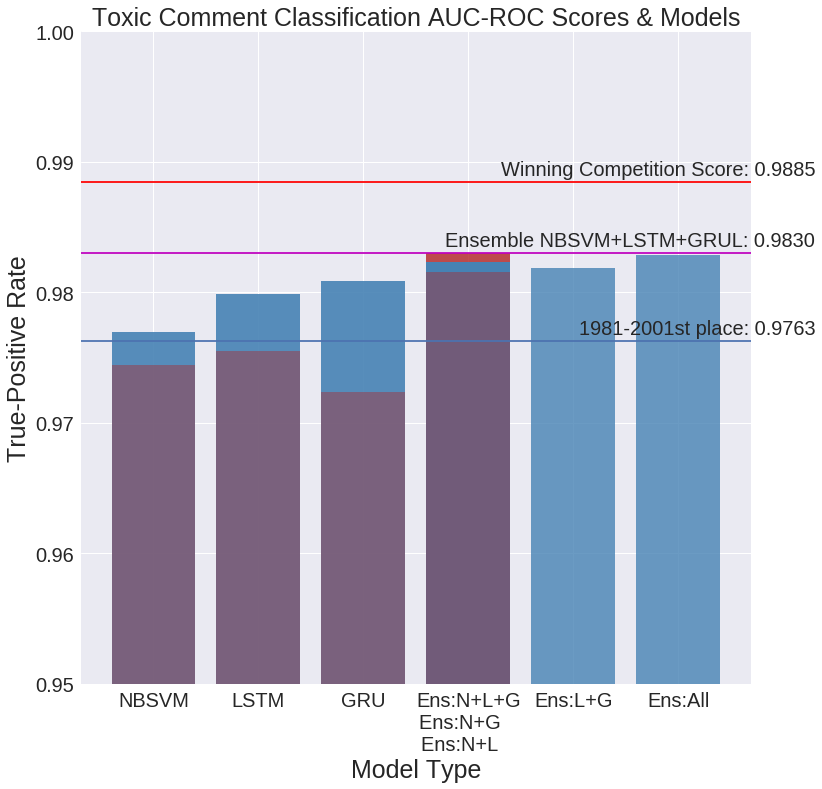

In [428]:
bar_visual()

### 6.2 Scatter Plot

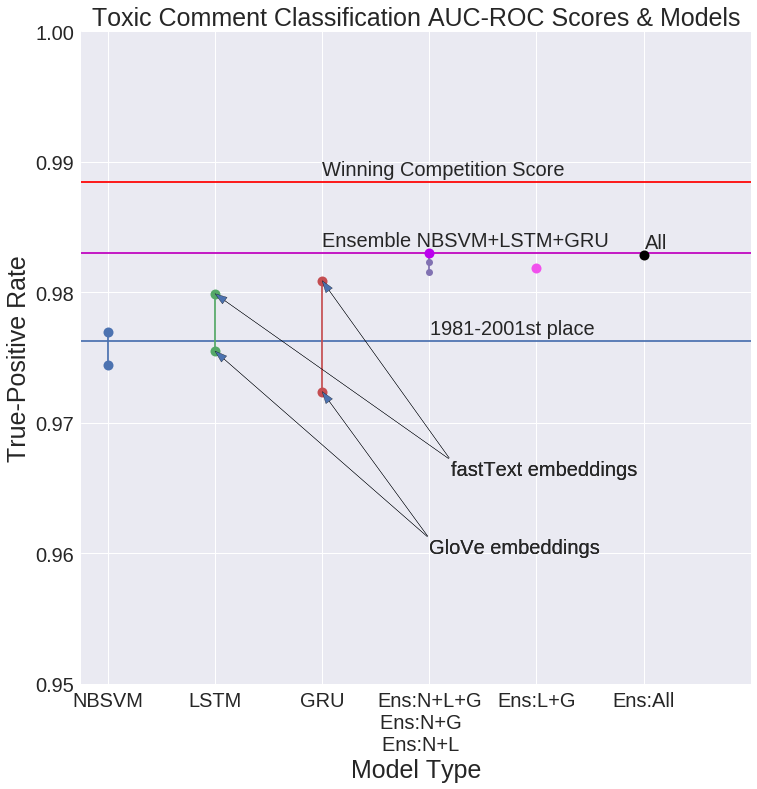

In [431]:
scatter_visual()

### 6.4 Data Stats

#### 6.4.1 Word Frequency

In [416]:
comment_lengths_train = train_df.comment_text.str.len()
comment_lengths_test  = test_df.comment_text.str.len()

Comment length distribution of Training Data


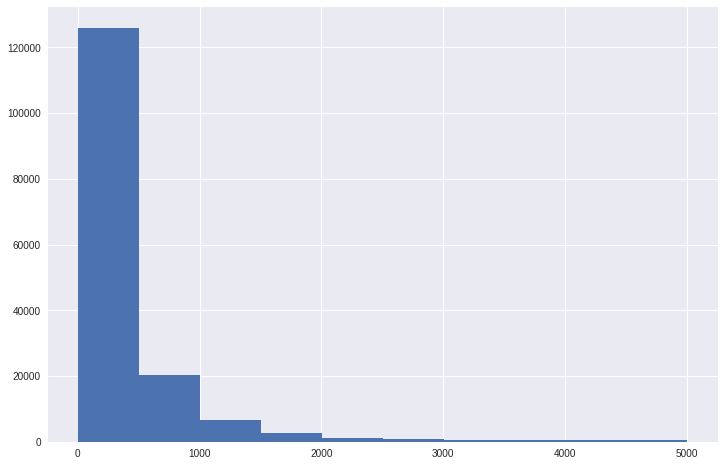

In [438]:
print("Comment length distribution of Training Data")
comment_lengths_train.hist(figsize=(12,8));

Comment length distribution of Testing Data


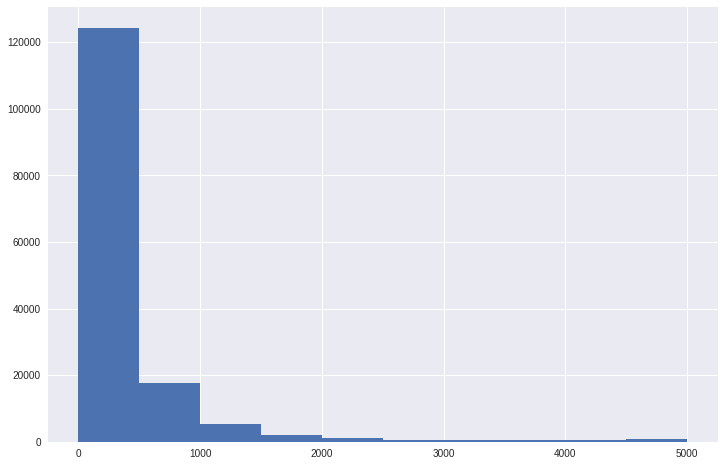

In [439]:
print("Comment length distribution of Testing Data")
comment_lengths_test.hist(figsize=(12,8));

### 6.4.2 Comment Toxicity

In [443]:
toxics = train_df[list_classes].sum()
toxics

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

I wonder if the distribution of toxic-type text in the testing data is the same as in the training data. I can get an idea by checking my best performing model, the NBSVM-LSTM-GRU Ensemble, with a True-Positive rate of 0.9830.

In [45]:
Ensemble_NBSVM_LSTM_GRU_predictions = pd.read_csv(PATH_COMP/'ensemble_nbsvm_lstm_gru_predictions.csv')

In [445]:
predicted_toxics = Ensemble_NBSVM_LSTM_GRU_predictions[list_classes].sum()
predicted_toxics

toxic            34344.977026
severe_toxic      3339.525630
obscene          19362.121195
threat             836.808538
insult           17248.985868
identity_hate     2898.387233
dtype: float64

In [492]:
# nontoxic comments
nontoxics_train = sum(1 - train_df[list_classes].max(axis=1))
nontoxics_test  = sum(1 - Ensemble_NBSVM_LSTM_GRU_predictions[list_classes].max(axis=1))

print(f'Nontoxics in Training Data: {nontoxics_train:>17}\nNontoxics in Testing Data (Predicted): {nontoxics_test:>.0f}')
print(f'Ratio nontoxics Train: {nontoxics_train/len(train_df):>20.2f}\nRatio nontoxics Test (Predicted): {nontoxics_test/len(test_df):>9.2f}')

Nontoxics in Training Data:            143346
Nontoxics in Testing Data (Predicted): 118796
Ratio nontoxics Train:                 0.90
Ratio nontoxics Test (Predicted):      0.78


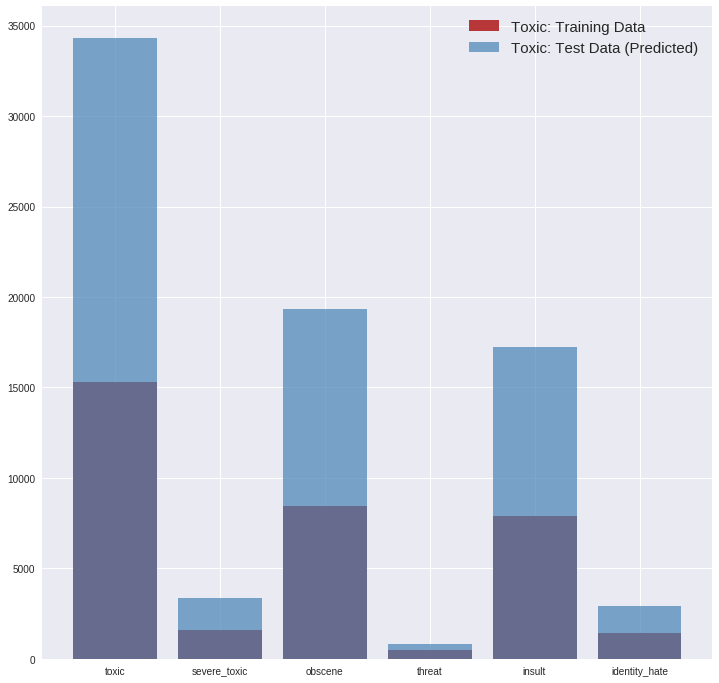

In [472]:
colors = ['steelblue','firebrick']
fg, ax = plt.subplots(figsize=(12,12), )
plt.bar([i for i in range(6)], toxics, color=colors[1], alpha=0.9)
plt.bar([i for i in range(6)], predicted_toxics, color=colors[0], alpha=0.7)
plt.xticks(np.arange(len(list_classes)), list_classes)
plt.legend(['Toxic: Training Data','Toxic: Test Data (Predicted)'], fontsize=15)
plt.show()

The ratios actually look similar.

## 7. Out-of-Dataset Testing

Finally, it's always good to test-drive your models and get a feel for how they perform. Sometimes this can reveal valuable insight into why a model may be underperforming, or lead to other ideas for improvement.

In [20]:
toxic_text = ['I think you are very fat.', 
              'Your shirt makes me want to renounce my citizenship.', 
              'What I hate about you is your face.', 
              'That sounds like something someone with no spine would say.']
nontoxic_text = ['There are seventy-five elephants in Chicago.', 'The sky is blue.', 'Where did you park my car?']

text = [i for i in toxic_text]
text.extend(nontoxic_text)
text = pd.DataFrame(text, index=None, columns=['comment_text'])

# For NB-SVM
text_doc = tfidf_vectorizer.transform(text["comment_text"])
# For RNNs
list_sentences_text = text["comment_text"].fillna("_na_").values
list_tokenized_text = tokenizer.texts_to_sequences(list_sentences_text)
input_text = pad_sequences(list_tokenized_text, maxlen=maxlen)

In [25]:
# NB-SVM
nbsvm_predictions = np.zeros((len(text), len(list_classes))) # NBSVM model wasnt saved so it's re-fitted
for i, clss in enumerate(list_classes):
    print('fit', clss)
    m, r = get_mdl(train_term_doc, train_df[clss])
    nbsvm_predictions[:,i] = m.predict_proba(text_doc.multiply(r))[:,1]

# LSTM:
model = BiLSTM()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.load_weights(fpath_LSTM)

lstm_predictions = model.predict(input_text, batch_size=1024, verbose=1)

# GRU-Conv:
model = BiGRU_ConvNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.load_weights(fpath_GRU)

gru_predictions = model.predict(input_text, batch_size=1024, verbose=1)

fit toxic
fit severe_toxic
fit obscene
fit threat
fit insult
fit identity_hate
7/7 [==============================] - 1s 94ms/step


If CV has gotten fast at real-time image analysis, NLP has the potential to be a whole world faster. 72ms is about the time it takes your brain to process a visual shape, forget analyzing an entire block of text.

In [26]:
predictions = (nbsvm_predictions + lstm_predictions + gru_predictions) / 3

In [27]:
predicted_text = pd.read_csv(PATH_COMP/'sample_submission.csv')
predicted_text.drop(columns=["id"], inplace=True)
predicted_text = predicted_text[:0]
predicted_text["comment_text"] = text["comment_text"]
predicted_text[list_classes] = predictions
predicted_text

,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text
0,0.787972,0.012439,0.107208,0.003304,0.652755,0.031449,I think you are very fat.
1,0.180767,0.001490,0.011164,0.000847,0.029337,0.001436,Your shirt makes me want to renounce my citize...
2,0.865179,0.041606,0.144977,0.021721,0.408337,0.043636,What I hate about you is your face.
3,0.035322,0.000524,0.003333,0.000199,0.006656,0.000262,That sounds like something someone with no spi...
4,0.012663,0.000308,0.001883,0.000521,0.003832,0.000446,There are seventy-five elephants in Chicago.
5,0.017501,0.000444,0.002564,0.000234,0.005640,0.000530,The sky is blue.
6,0.079832,0.001786,0.009042,0.001148,0.019915,0.000740,Where did you park my car?


In [29]:
predicted_text.to_csv(PATH_COMP/'dummy_predictions.csv', index=False)

In [111]:
def analyze_comments(predicted_text, list_classes, threshold=0.5):
    for i in range(len(predicted_text.comment_text)):
        list_classes = np.asarray(list_classes)
        toxic_idxs = np.where(predicted_text[list_classes].iloc[i] > threshold)        
        toxic_detections = list_classes[toxic_idxs]
        toxic_values = predicted_text[toxic_detections].iloc[i]
        
        print(f'"{predicted_text.iloc[i].comment_text}"')
        for keyval in toxic_values.items():
            print(f'{keyval[0]}: {keyval[1]:.4f}')
        if len(toxic_idxs[0]) == 0:
            print(f'Nontoxic')
        print()
        
analyze_comments(predicted_text, list_classes)

"I think you are very fat."
toxic: 0.7880
insult: 0.6528

"Your shirt makes me want to renounce my citizenship."
Nontoxic

"What I hate about you is your face."
toxic: 0.8652

"That sounds like something someone with no spine would say."
Nontoxic

"There are seventy-five elephants in Chicago."
Nontoxic

"The sky is blue."
Nontoxic

"Where did you park my car?"
Nontoxic



Not so bad, although the not-so-subtle jab does get through.

## Notes

This notebook does not demonstrate Cross Validation. The built-in Keras `validation_split` parameter in `Model.fit` sets aside a fraction of the data *before* it is shuffled.

---

## Asides

### Aside 1: Terms

- LSTM: [Long Short-Term Memory Network](http://colah.github.io/posts/2015-08-Understanding-LSTMs/#lstm-networks)
- GRU : [Gated Recurrent Unit Network](http://colah.github.io/posts/2015-08-Understanding-LSTMs/#variants-on-long-short-term-memory)
- NB-SVM: [Naïve Bayes Support Vector Machine](https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf)
- ConvNet: [Convolutional Neural Network](http://cs231n.github.io/convolutional-networks/)
- RNN: [Recurrent Neural Network](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
- AUC-ROC: [Area Under Curve: Region of Operating Characteristics](http://gim.unmc.edu/dxtests/roc3.htm)

---

### Aside 2: Sequence Padding: Keras vs. PyTorch

PyTorch's `torchtext.data.BucketIterator` pads by batch, whereas Keras' `keras.preprocessing.text.pad_sequences` pads the entire dataset. 

This points to some memory savings in PyTorch and makes it some to pay attention to as the library and as FastAI integration develop. ie: Keras pads all sequences in the dataset to `maxlen`, but PyTorch sorts each batch by length and pads to the longest-length sequence in each batch. This seems like something doable in TensorFlow that's hidden by Keras' level of abstraction.

---

### Aside 3: checking bcolz compressor

Making sure I'm using the [bcolz compression library](https://github.com/Blosc/bcolz) correctly. Restarting this notebook requires a ~27 second wait for input data preprocessing. One way to handle this is to use a subset of the data during development, but the dataset is not so large as to necessitate that. Instead I save the preprocessed dataset as compressed arrays on disk for quick iteration. 

Pandas' `to_feather` is another good solution for temporary storage (not compressed), but it's meant for DataFrames - so I opted to use bcolz instead of a few extra processing steps. At a write-read-check wall time of under 500ms, the extra speed of  `to_feather` is not necessary for me.

Below I make sure an array is written and read back from disk correctly.

In [43]:
%%time
# compressed data directory
os.makedirs(PATH_COMP/'tmp/bc', exist_ok=True)

# write compressed array
fname = 'tmp/bc/input_train'
bcolz.carray(input_train, rootdir=PATH_COMP/fname, mode='w').flush()
# read compressed array
temp = bcolz.open(rootdir=PATH_COMP/fname)

print(False not in np.isclose(temp, input_train)) # True if all good

True
CPU times: user 376 ms, sys: 176 ms, total: 552 ms
Wall time: 338 ms


Below are timings of the data preproc and loading steps. This reveals what should be written to disk if we want fast notebook execution.

In [103]:
%%time

print("Tokenizer & Vocabulary initialization")
%time tokenizer = Tokenizer(num_words=max_feat, lower=True, oov_token='<unk>')
%time tokenizer.fit_on_texts(list(list_sentences_train))

print("\nTokenization & Numericalization")
%time list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
%time list_tokenized_test  = tokenizer.texts_to_sequences(list_sentences_test)

print("\nPadding")
%time input_train = sequence.pad_sequences(list_tokenized_train, maxlen=maxlen)
%time input_test  = sequence.pad_sequences(list_tokenized_test, maxlen=maxlen)

print("\nTotal:")

Tokenizer & Vocabulary initialization
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 15 µs
CPU times: user 10.4 s, sys: 68 ms, total: 10.5 s
Wall time: 10.5 s

Tokenization & Numericalization
CPU times: user 7.72 s, sys: 24 ms, total: 7.74 s
Wall time: 7.74 s
CPU times: user 6.51 s, sys: 20 ms, total: 6.53 s
Wall time: 6.53 s

Padding
CPU times: user 1.66 s, sys: 52 ms, total: 1.71 s
Wall time: 1.47 s
CPU times: user 1.55 s, sys: 68 ms, total: 1.62 s
Wall time: 1.38 s

Total:
CPU times: user 27.9 s, sys: 232 ms, total: 28.1 s
Wall time: 27.7 s


We can even turn this into a pie-chart for a quick-glance visual representation:

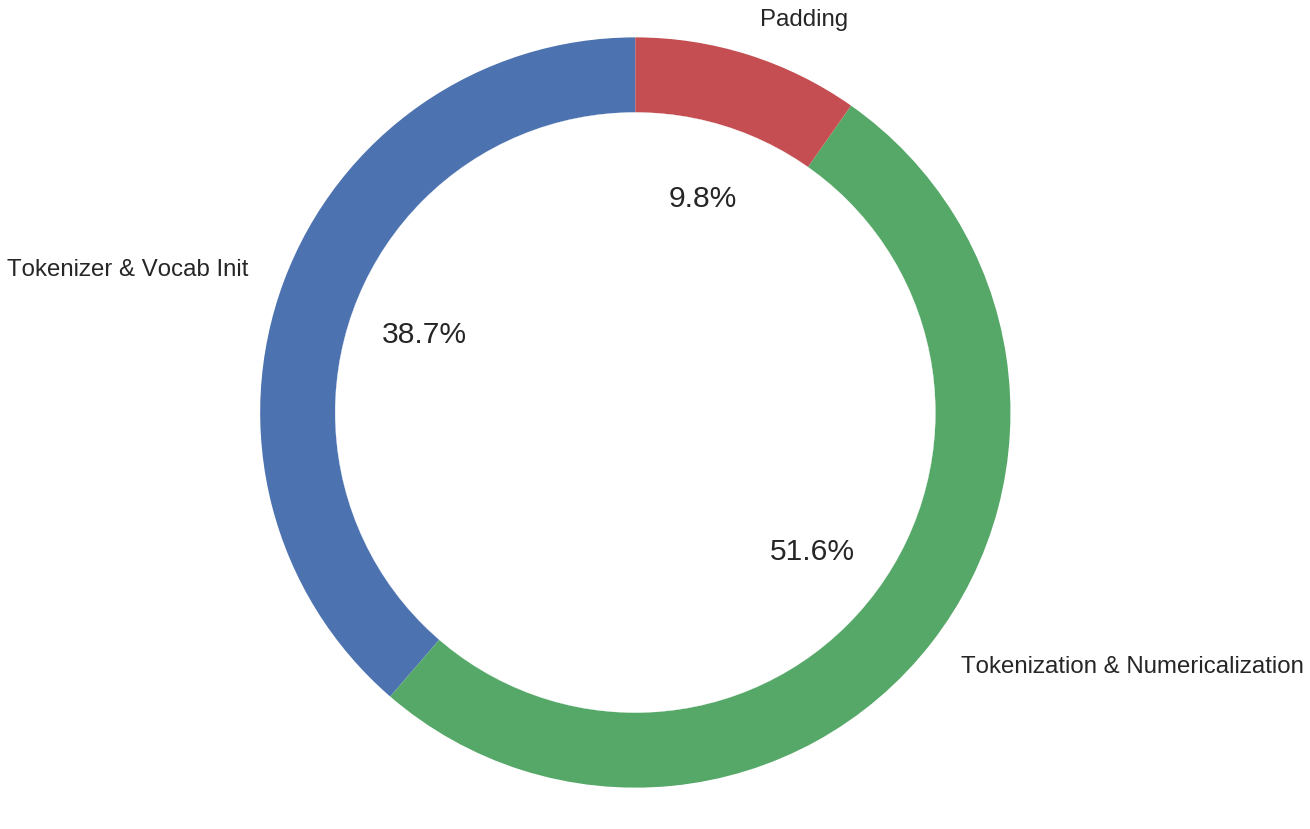

CPU times: user 29.8 s, sys: 0 ns, total: 29.8 s
Wall time: 29 s


In [437]:
%%time
def get_pie_chart_time_data():
    times = []

    t0 = time.time()
    tokenizer = Tokenizer(num_words=max_feat, lower=True, oov_token='<unk>')
    tokenizer.fit_on_texts(list(list_sentences_train))
    times.append(time.time() - t0)

    t0 = time.time()
    list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
    list_tokenized_test  = tokenizer.texts_to_sequences(list_sentences_test)
    times.append(time.time() - t0)

    t0 = time.time()
    input_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
    input_test  = pad_sequences(list_tokenized_test, maxlen=maxlen)
    times.append(time.time() - t0)
    
    return times

def pie_time_visualize(times):
    # pie chart
    plt.style.use('seaborn')
    fg, ax = plt.subplots(figsize=(15,15))
    _, text, autotexts = ax.pie(times, 
                                labels=['Tokenizer & Vocab Init', 'Tokenization & Numericalization', 'Padding'], 
                                shadow=False, autopct='%1.1f%%', startangle=90)
    # text size
    for i,a in enumerate(autotexts):
        autotexts[i].set_fontsize(30)
    for i,t in enumerate(text):
        text[i].set_fontsize(24)

    ax.axis('equal')
    # pie chart -> donut chart
    circle = plt.Circle((0,0), 0.8, color='white')
    p = plt.gcf()
    p.gca().add_artist(circle)
    # display
    plt.show()

times = get_pie_chart_time_data()
pie_time_visualize(times)

Finally, an example of the speedup of saving data to disk:

In [113]:
%%time
PATH_BC = PATH_COMP/'tmp/bc'
os.makedirs(PATH_BC, exist_ok=True)

# WRITE
t0 = time.time()
bcolz.carray(list_tokenized_train, rootdir=PATH_BC/'list_tokenized_train', mode='w').flush()
bcolz.carray(list_tokenized_test, rootdir=PATH_BC/'list_tokenized_test', mode='w').flush()
bcolz.carray(input_train, rootdir=PATH_BC/'input_train', mode='w').flush()
bcolz.carray(input_test,  rootdir=PATH_BC/'input_test',  mode='w').flush()
print(f'TIME: COMPRESS & WRITE\n{time.time()-t0:.4f} s')

# READ
t0 = time.time()
list_tokenized_train = bcolz.open(rootdir=PATH_BC/'list_tokenized_train')
list_tokenized_test  = bcolz.open(rootdir=PATH_BC/'list_tokenized_test')
input_train = bcolz.open(rootdir=PATH_BC/'input_train')
input_test  = bcolz.open(rootdir=PATH_BC/'input_test')
print(f'TIME: DECOMPRESS & READ\n{time.time()-t0:.4f} s')

TIME: COMPRESS & WRITE
19.7980 s
TIME: DECOMPRESS & READ
0.1103 s
CPU times: user 11.5 s, sys: 7.68 s, total: 19.1 s
Wall time: 19.9 s


With the data already on disk, this step can take 0.1 seconds instead of 27, about 0.37% the original time.

**NOTE**: it does take a non-trivial amount of time for bcolz to deal with existing data on disk. Even though it's read/write mode `'w'` automatically overwrites what's on disk, having to do so for the data above takes an average of 50 seconds for write-&-read. It takes only an average of 18.5 seconds if the directory is empty. 

However the intended use case is only to speed up read (load) time, so this isn't an issue; Only something to keep in mind if you are overwriting compressed bcolz arrays.

Overwriting bcolz data, while that data is currently loaded in an object, is a *bad* idea. Since the data lives on disk, the bcolz library has to juggle overwriting with maintaining the object's integrity.

Lastly, data loaded from bcolz is of the `carray` datatype, which is meant to retain most numpy.ndarray functionality while living on disk. To move the object to memory call:

`data_object = np.asarray(data_object)`

Where `data_object` is initially loaded as a `bcolz.carray` object.

---

### Aside 4: Taking a look at embedding vectors

In [14]:
# GloVe 50d - First Vector
for o in open(EMBEDDING_GLOVE):
    print(len(o.split()) - 1)
    print(o)
    break

50
the 0.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.49688 -0.17862 -0.00066023 -0.6566 0.27843 -0.14767 -0.55677 0.14658 -0.0095095 0.011658 0.10204 -0.12792 -0.8443 -0.12181 -0.016801 -0.33279 -0.1552 -0.23131 -0.19181 -1.8823 -0.76746 0.099051 -0.42125 -0.19526 4.0071 -0.18594 -0.52287 -0.31681 0.00059213 0.0074449 0.17778 -0.15897 0.012041 -0.054223 -0.29871 -0.15749 -0.34758 -0.045637 -0.44251 0.18785 0.0027849 -0.18411 -0.11514 -0.78581



In [15]:
# fastText 300d - First Vector
i = 0
for o in open(EMBEDDING_FASTTEXT):
    if i == 0:
        print(o)
    if i == 2: 
        print(o)
        break
    i += 1

2000000 300

the 0.0231 0.0170 0.0157 -0.0773 0.1088 0.0031 -0.1487 -0.2672 -0.0357 -0.0487 0.0807 0.1532 -0.0739 -0.0291 -0.0445 -0.0014 0.1014 0.0186 -0.0253 0.0200 -0.0026 -0.0179 0.0005 0.0054 -0.0134 0.0233 -0.0755 -0.0156 0.0415 -0.4985 0.0410 -0.0616 0.0047 0.0325 -0.0162 -0.0172 0.0988 0.0766 -0.0796 -0.0345 0.0124 -0.1007 -0.0292 -0.0762 -0.1261 -0.0531 0.0424 0.0144 -0.0683 0.2859 0.0399 0.0201 0.3240 -0.0656 -0.0497 0.0090 0.0902 -0.0138 -0.0412 -0.0297 0.3139 -0.1428 0.0166 -0.0219 -0.0575 0.1359 -0.1655 0.0019 0.0323 -0.0013 -0.3033 -0.0091 0.1462 0.1860 -0.0524 0.1886 -0.7372 -0.0248 -0.0205 0.0022 0.5988 -0.0359 -0.0269 -0.0483 0.0109 -0.0044 0.0592 0.0174 0.0010 -0.0012 -0.0251 0.4620 -0.0443 -0.0350 0.0115 0.1496 0.3125 -0.0091 0.2517 0.0654 0.0237 -0.0432 0.0952 0.0650 -0.2932 0.0630 0.0236 0.0340 -0.0012 0.0889 -0.0006 -0.1736 0.0374 0.0313 -0.6184 0.0282 -0.3836 0.0589 0.2443 0.0602 0.0057 -0.0038 0.1352 0.0053 0.0193 -0.0213 0.0248 0.0214 0.2334 -0.0438 0.0527 0.02

### Aside 5: 'None' Label

Do the neural networks improve if I add a 'None' label? This is done for the NB-SVM. The use of a neutral 'background' class is used in CV in Object Detection ... it sounds like it should offer improvement: ie: allow the NN to pick a 'none' label instead of not picking any classes: explicit vs. implicit. I would experiment with this in a deeper analysis.

The summary below suggests that about 90% of the training data is not labelled as any kind of toxic (a mean of 0.898 across the dataset for a binary label). -- **NOTE** the 'mean' row does not sum to 1 because some comments have multiple toxic-type labels.

In [13]:
# summary of the dataset
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# End